SNR = 0 dB | NRMSE = 0.6209 | BER = 0.3162 | SER = 0.7093


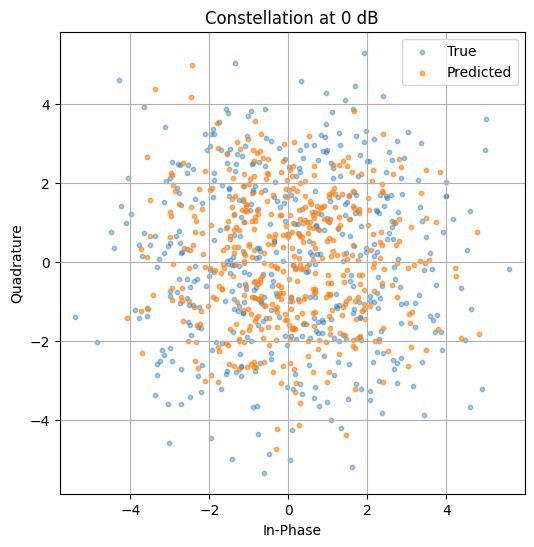

SNR = 5 dB | NRMSE = 0.5410 | BER = 0.2701 | SER = 0.6312


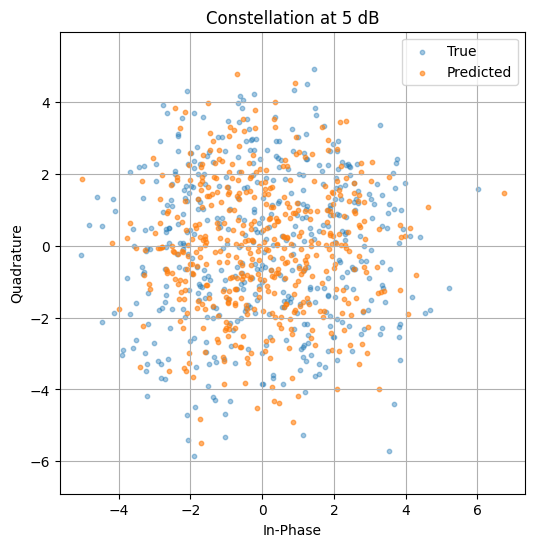

SNR = 10 dB | NRMSE = 0.4819 | BER = 0.2511 | SER = 0.5705


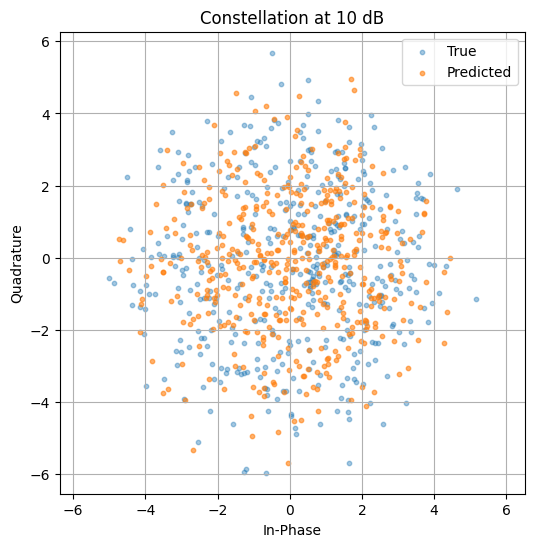

SNR = 15 dB | NRMSE = 0.4705 | BER = 0.2435 | SER = 0.5770


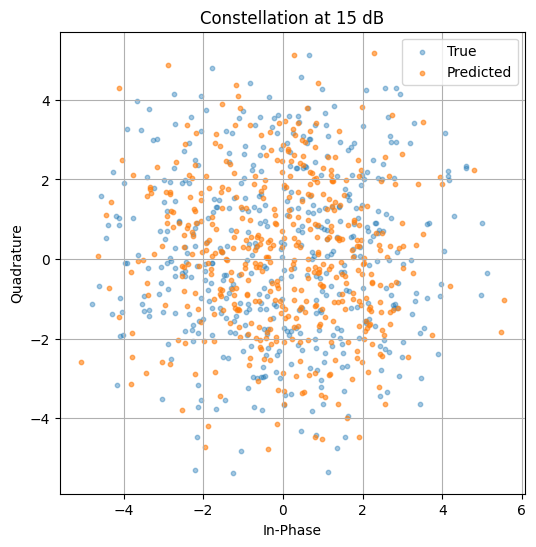

SNR = 20 dB | NRMSE = 0.3029 | BER = 0.1470 | SER = 0.3731


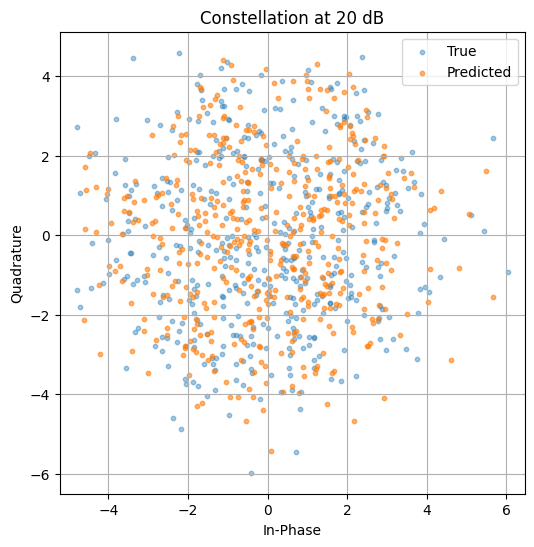

SNR = 25 dB | NRMSE = 0.3816 | BER = 0.1773 | SER = 0.4469


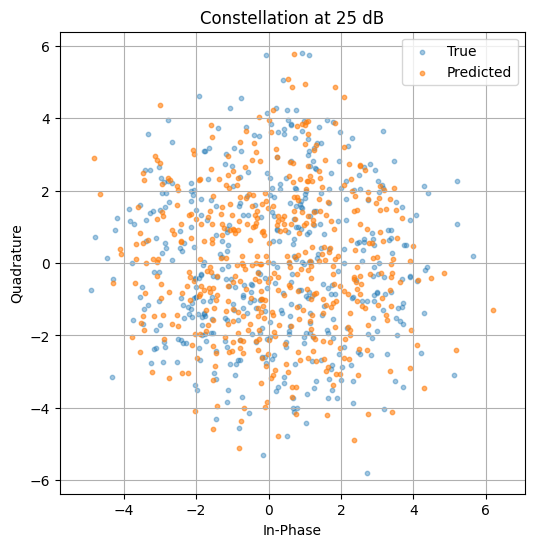

SNR = 30 dB | NRMSE = 0.5275 | BER = 0.2614 | SER = 0.6247


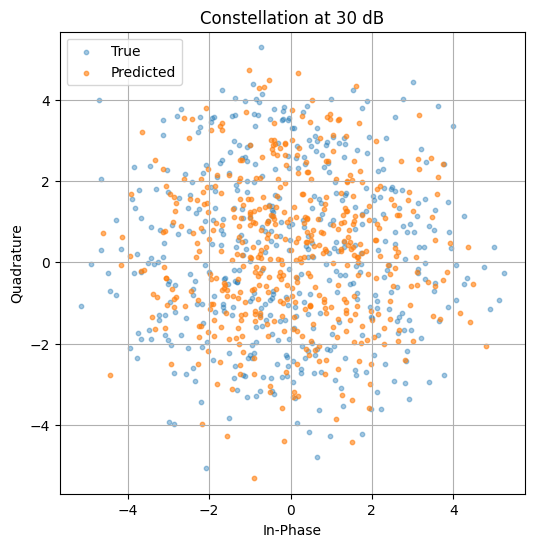

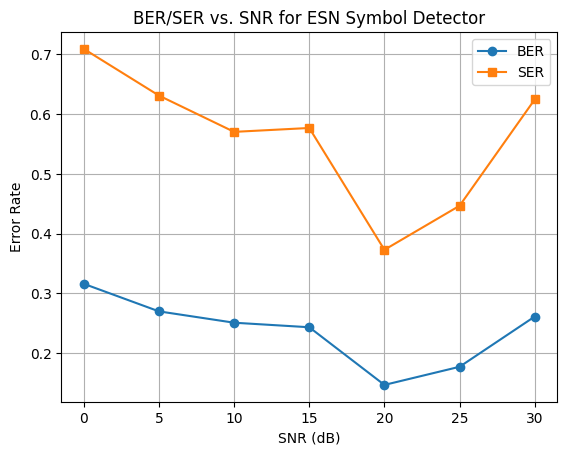

In [75]:
# Full ESN Symbol Detection Pipeline for MIMO-OFDM (SISO Version)
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from numpy.fft import fft

# --------------------------- Helper Functions ---------------------------
def qam_modulate(bits, mod_order):
    M = mod_order
    k = int(np.log2(M))
    assert len(bits) % k == 0, "Bit length must be divisible by log2(M)"

    bit_groups = bits.reshape((-1, k))
    gray_map = np.array([0, 1, 3, 2])
    I = gray_map[bit_groups[:, 0]*2 + bit_groups[:, 1]]
    Q = gray_map[bit_groups[:, 2]*2 + bit_groups[:, 3]]
    constellation = (2*I - 3) + 1j * (2*Q - 3)
    norm_const = np.sqrt(10)  # Normalization for 16-QAM
    return constellation / norm_const

def qam_demodulate(symbols, mod_order):
    levels = np.array([-3, -1, 1, 3])
    symbols = symbols * np.sqrt(10)
    re = np.reshape(symbols.real, (-1, 1))
    im = np.reshape(symbols.imag, (-1, 1))
    re_q = levels[np.argmin(np.abs(re - levels), axis=1)]
    im_q = levels[np.argmin(np.abs(im - levels), axis=1)]
    bits = []
    gray_map = {0: [0, 0], 1: [0, 1], 3: [1, 1], 2: [1, 0]}
    for r, i in zip(re_q, im_q):
        idx_r = int((r + 3) // 2)
        idx_i = int((i + 3) // 2)
        bits.extend(gray_map[idx_r])
        bits.extend(gray_map[idx_i])
    return np.array(bits[:len(symbols) * 4])

def generate_channel(L=64, decay_factor=0.2):
    taps = np.arange(L)
    pdp = np.exp(-decay_factor * taps)
    pdp /= np.sum(pdp)
    real = np.random.normal(0, np.sqrt(pdp / 2), L)
    imag = np.random.normal(0, np.sqrt(pdp / 2), L)
    return real + 1j * imag

def rapp_model(signal, clip_level_db=3, r=1):
    A = np.abs(signal)
    beta = np.sqrt(10 ** (clip_level_db / 10))
    g_A = A / ((1 + (A / beta) ** (2 * r)) ** (1 / (2 * r)))
    return g_A * np.exp(1j * np.angle(signal))

def add_awgn(signal, snr_db):
    power = np.mean(np.abs(signal) ** 2)
    noise_power = power / (10 ** (snr_db / 10))
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

def initialize_esn(input_size, reservoir_size, spectral_radius=0.98, connectivity=0.2):
    Win = np.random.uniform(-1, 1, (reservoir_size, input_size))
    W_sparse = scipy.sparse.rand(reservoir_size, reservoir_size, density=connectivity)
    W = W_sparse.toarray()
    W[W != 0] = np.random.uniform(-1, 1, size=W[W != 0].shape)
    eigvals = np.linalg.eigvals(W)
    W *= spectral_radius / np.max(np.abs(eigvals))
    return Win, W

def train_esn(x_input, y_target, Win, W, washout=50, delay=1):
    T = x_input.shape[0]
    x = np.zeros((W.shape[0],))
    X_collect, Y_collect = [], []
    for t in range(T):
        u = x_input[t]
        x = np.tanh(Win @ u + W @ x)
        if t >= washout + delay:
            X_collect.append(np.hstack([x_input[t - delay], x]))
            Y_collect.append(y_target[t])
    S = np.array(X_collect)
    Y = np.array(Y_collect)
    Wout = np.linalg.pinv(S) @ Y
    return Wout, S, Y

def test_esn(x_input, y_target, Win, W, Wout, washout=50, delay=1):
    T = x_input.shape[0]
    x = np.zeros((W.shape[0],))
    y_preds = []
    for t in range(T):
        u = x_input[t]
        x = np.tanh(Win @ u + W @ x)
        if t >= washout + delay:
            concat = np.hstack([x_input[t - delay], x])
            y_hat = concat @ Wout
            y_preds.append(y_hat)
    Y_pred = np.array(y_preds)
    Y_true = y_target[washout + delay:]
    mse = np.mean((Y_pred - Y_true) ** 2)
    nrmse = np.sqrt(mse / np.var(Y_true))
    return Y_pred, Y_true, nrmse

def plot_constellation(y_pred, y_true, snr_db):
    pred_complex = fft(y_pred[:, 0] + 1j * y_pred[:, 1]) * np.sqrt(10)
    true_complex = fft(y_true[:, 0] + 1j * y_true[:, 1]) * np.sqrt(10)
    plt.figure(figsize=(6,6))
    plt.scatter(true_complex.real, true_complex.imag, s=10, label="True", alpha=0.4)
    plt.scatter(pred_complex.real, pred_complex.imag, s=10, label="Predicted", alpha=0.6)
    plt.grid(True)
    plt.axis("equal")
    plt.title(f"Constellation at {snr_db} dB")
    plt.xlabel("In-Phase")
    plt.ylabel("Quadrature")
    plt.legend()
    plt.show()

def compute_ber_ser(y_pred, y_true, mod_order):
    pred_complex = fft(y_pred[:, 0] + 1j * y_pred[:, 1])
    true_complex = fft(y_true[:, 0] + 1j * y_true[:, 1])
    norm_const = np.sqrt(10)
    pred_scaled = pred_complex * norm_const
    true_scaled = true_complex * norm_const

    def quantize_qam(symbols):
        levels = np.array([-3, -1, 1, 3])
        re = np.reshape(symbols.real, (-1, 1))
        im = np.reshape(symbols.imag, (-1, 1))
        re_q = levels[np.argmin(np.abs(re - levels), axis=1)]
        im_q = levels[np.argmin(np.abs(im - levels), axis=1)]
        return re_q + 1j * im_q

    pred_q = quantize_qam(pred_scaled)
    true_q = quantize_qam(true_scaled)
    ser = np.mean(pred_q != true_q)

    pred_bits = qam_demodulate(pred_q / norm_const, mod_order)
    true_bits = qam_demodulate(true_q / norm_const, mod_order)
    ber = np.mean(pred_bits != true_bits)
    return ber, ser

# --------------------------- Parameters ---------------------------
N = 512
Mcp = 63
mod_order = 16
clip_level_dB = 3
shape_param = 1
reservoir_size = 300
input_scaling = 5.0

# --------------------------- SNR Sweep ---------------------------
snr_dbs = np.arange(0, 31, 5)
ber_list, ser_list = [], []

for snr_db in snr_dbs:
    bits = np.random.randint(0, 2, int(np.log2(mod_order)) * N)
    symbols = qam_modulate(bits, mod_order)
    ofdm_td = np.fft.ifft(symbols)
    ofdm_cp = np.concatenate([ofdm_td[-Mcp:], ofdm_td])
    ofdm_nl = rapp_model(ofdm_cp, clip_level_dB, shape_param)
    h = generate_channel(L=64)
    y = np.convolve(ofdm_nl, h, mode='full')[:len(ofdm_cp)]
    y_noisy = add_awgn(y, snr_db)

    tx_no_cp = ofdm_cp[Mcp:]
    rx_no_cp = y_noisy[Mcp:]
    x_esn = np.stack([rx_no_cp.real, rx_no_cp.imag], axis=1) * input_scaling
    y_esn = np.stack([tx_no_cp.real, tx_no_cp.imag], axis=1)

    Win, W = initialize_esn(input_size=2, reservoir_size=reservoir_size)
    Wout, _, _ = train_esn(x_esn, y_esn, Win, W)
    y_pred, y_true, nrmse = test_esn(x_esn, y_esn, Win, W, Wout)

    ber, ser = compute_ber_ser(y_pred, y_true, mod_order)
    ber_list.append(ber)
    ser_list.append(ser)

    print(f"SNR = {snr_db} dB | NRMSE = {nrmse:.4f} | BER = {ber:.4f} | SER = {ser:.4f}")
    plot_constellation(y_pred, y_true, snr_db)

# --------------------------- Plot SER/BER vs SNR ---------------------------
plt.figure()
plt.plot(snr_dbs, ber_list, '-o', label="BER")
plt.plot(snr_dbs, ser_list, '-s', label="SER")
plt.grid(True)
plt.xlabel("SNR (dB)")
plt.ylabel("Error Rate")
plt.title("BER/SER vs. SNR for ESN Symbol Detector")
plt.legend()
plt.show()


In [73]:
import numpy as np

# Simple ESN class
class SimpleESN:
    def __init__(self, n_inputs, n_reservoir, n_outputs, spectral_radius=0.95, input_scale=1.0, connectivity=0.2):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.Win = input_scale * np.random.uniform(-1, 1, (n_reservoir, n_inputs))
        self.W = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
        self.W[np.random.rand(*self.W.shape) > connectivity] = 0
        rho = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / rho
        self.Wfb = np.random.uniform(-0.01, 0.01, (n_reservoir, n_outputs))  # Small feedback
        self.Wout = None
        self.x = np.zeros(n_reservoir)

    def update(self, u, y=None):
        fb = y if y is not None else np.zeros(self.n_outputs)
        self.x = np.tanh(self.Win @ u + self.W @ self.x + self.Wfb @ fb)
        return self.x

    def train(self, U, Y, washout=10):
        states = []
        self.x = np.zeros(self.n_reservoir)
        for t in range(U.shape[0]):
            x = self.update(U[t], Y[t-1] if t > 0 else None)
            if t >= washout:
                states.append(np.concatenate([U[t], x]))
        states = np.vstack(states)
        self.Wout = np.linalg.pinv(states) @ Y[washout:]
    
    def predict(self, U):
        y_hat = []
        self.x = np.zeros(self.n_reservoir)
        for u in U:
            x = self.update(u)
            y = np.concatenate([u, x]) @ self.Wout
            y_hat.append(y)
        return np.vstack(y_hat)

# OFDM params
N = 64  # subcarriers
cp_len = 4
mod = 'QPSK'
constellation = (1/np.sqrt(2)) * np.array([1+1j, 1-1j, -1+1j, -1-1j])
bits_per_symbol = 2

def generate_symbols():
    idx = np.random.randint(0, 4, N)
    return constellation[idx], idx

def ifft(signal):
    return np.fft.ifft(signal) * np.sqrt(N)

def add_cp(signal):
    return np.concatenate([signal[-cp_len:], signal])

def remove_cp(signal):
    return signal[cp_len:]

def channel(tx, snr_db, taps=2):
    h = (np.random.randn(taps) + 1j * np.random.randn(taps)) / np.sqrt(2)
    rx = np.convolve(tx, h)[:len(tx)]  # Simple convolution
    noise_var = 10**(-snr_db/10) * np.mean(np.abs(tx)**2)
    noise = np.sqrt(noise_var/2) * (np.random.randn(len(rx)) + 1j * np.random.randn(len(rx)))
    return rx + noise

def nearest_const(s_hat):
    dist = np.abs(s_hat[:, np.newaxis] - constellation[np.newaxis, :])
    return np.argmin(dist, axis=1)

# Simulation
def run_sim(snr_db, num_symbols=100, train_every=10):
    esn = SimpleESN(n_inputs=2, n_reservoir=50, n_outputs=2)  # Real/imag
    errors = 0
    total_bits = 0
    for i in range(num_symbols):
        if i % train_every == 0:
            # Train
            s_freq, _ = generate_symbols()
            s_time = ifft(s_freq)
            tx = add_cp(s_time)
            rx = channel(tx, snr_db)
            rx_no_cp = remove_cp(rx)
            U = np.vstack([np.real(rx_no_cp), np.imag(rx_no_cp)]).T
            Y = np.vstack([np.real(s_time), np.imag(s_time)]).T
            esn.train(U, Y)
        # Test
        s_freq, true_idx = generate_symbols()
        s_time = ifft(s_freq)
        tx = add_cp(s_time)
        rx = channel(tx, snr_db)
        rx_no_cp = remove_cp(rx)
        U = np.vstack([np.real(rx_no_cp), np.imag(rx_no_cp)]).T
        y_hat = esn.predict(U)
        s_hat_time = y_hat[:,0] + 1j * y_hat[:,1]
        s_hat_freq = np.fft.fft(s_hat_time) / np.sqrt(N)
        pred_idx = nearest_const(s_hat_freq)
        errors += np.sum(pred_idx != true_idx)
        total_bits += N * bits_per_symbol
    ber = errors / total_bits
    return ber

# Run for different SNR
snrs = [10, 20, 30]
bers = [run_sim(snr) for snr in snrs]
print('SNR (dB):', snrs)
print('BER:', bers)

SNR (dB): [10, 20, 30]
BER: [0.36796875, 0.388125, 0.378671875]


Shape of transmitted symbols: (1024, 4)
Shape of received symbols: (1024, 16)
Shape of channel realizations: (1024, 16, 4)
Epoch 0, Loss: 2.2710342407226562
Epoch 10, Loss: 0.9128586053848267
Epoch 20, Loss: 0.8991676568984985
Epoch 30, Loss: 0.7882639169692993
Epoch 40, Loss: 0.7344596982002258
Epoch 50, Loss: 0.686811089515686
Epoch 60, Loss: 0.6479930877685547
Epoch 70, Loss: 0.6141365170478821
Epoch 80, Loss: 0.5852905511856079
Epoch 90, Loss: 0.5602376461029053
Shape of equalized symbols: (1024, 4)


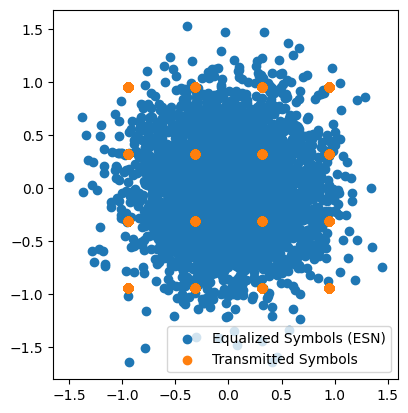

Shape of effective noise variance: (1024, 4)
Noise variance (effective): 1.3455335
Noise variance (estimated): 0.20000003
SER with ESN: tf.Tensor(0.932373046875, shape=(), dtype=float64)
SER with spatial correlation (ESN): tf.Tensor(0.930908203125, shape=(), dtype=float64)
Uncoded SER (ESN): tf.Tensor(0.936309814453125, shape=(), dtype=float64)
Coded BER (ESN): 0.498626708984375
XLA can lead to reduced numerical precision. Use with care.


2025-08-04 13:40:49.290050: I external/local_xla/xla/service/service.cc:168] XLA service 0x34659f00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-04 13:40:49.290073: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-04 13:40:49.355933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-04 13:40:49.397961: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mapper_9/assert_greater_equal/Assert/Assert
2025-08-04 13:40:49.398058: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator flat_fading_channel_5/apply_flat_fading_channel_5/awgn/assert_greater_equal/Assert/Assert
2025-08-04 13:40:49.398110: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator flat_fading_channel_5/apply_flat_fading_chan

ResourceExhaustedError: Exception encountered when calling layer 'model' (type Model).

Out of memory while trying to allocate 12616466816 bytes. [Op:__inference_call_26919]

Call arguments received by layer 'model' (type Model):
  • batch_size=tf.Tensor(shape=(), dtype=int32)
  • ebno_db=tf.Tensor(shape=(), dtype=float32)

In [82]:
# -*- coding: utf-8 -*-

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# GPU Configuration
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    os.system("pip install sionna")
    import sionna

# Set random seed for reproducibility
sionna.config.seed = 42

# Configure TensorFlow to allocate only as much GPU memory as needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Import required classes from Sionna
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

# ESN Layer Definition
class ESN(tf.keras.layers.Layer):
    def __init__(self, reservoir_size=1000, spectral_radius=0.99, sparsity=0.1, input_scaling=1.0, num_tx_ant=4, num_rx_ant=16):
        super(ESN, self).__init__()
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.input_scaling = input_scaling
        self.num_tx_ant = num_tx_ant
        self.num_rx_ant = num_rx_ant
        self.state_size = reservoir_size

    def build(self, input_shape):
        input_dim = self.num_rx_ant * 2
        self.W_in = self.add_weight(
            name='W_in',
            shape=(input_dim, self.reservoir_size),
            initializer=tf.random_uniform_initializer(minval=-self.input_scaling, maxval=self.input_scaling),
            trainable=False
        )
        W_res = tf.random.uniform([self.reservoir_size, self.reservoir_size], -1.0, 1.0)
        mask = tf.random.uniform([self.reservoir_size, self.reservoir_size]) < self.sparsity
        W_res = tf.where(mask, W_res, tf.zeros_like(W_res))
        eigenvalues = tf.linalg.eigvals(W_res)
        max_eig = tf.reduce_max(tf.abs(eigenvalues))
        W_res = W_res * (self.spectral_radius / max_eig)
        self.W_res = self.add_weight(
            name='W_res',
            shape=(self.reservoir_size, self.reservoir_size),
            initializer=tf.constant_initializer(W_res.numpy()),
            trainable=False
        )
        self.W_out = self.add_weight(
            name='W_out',
            shape=(self.reservoir_size, self.num_tx_ant * 2),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b_out = self.add_weight(
            name='b_out',
            shape=(self.num_tx_ant * 2,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs, states=None):
        if states is None:
            states = tf.zeros([tf.shape(inputs)[0], self.reservoir_size], dtype=tf.float32)
        inputs_flat = tf.reshape(inputs, [tf.shape(inputs)[0], -1])
        reservoir_input = tf.matmul(inputs_flat, self.W_in)
        reservoir_state = tf.matmul(states, self.W_res)
        new_state = tf.tanh(reservoir_input + reservoir_state)
        output = tf.matmul(new_state, self.W_out) + self.b_out
        output = tf.reshape(output, [tf.shape(inputs)[0], self.num_tx_ant, 2])
        return output, new_state

    def get_initial_state(self, inputs):
        return tf.zeros([tf.shape(inputs)[0], self.reservoir_size], dtype=tf.float32)

def esn_equalizer(y, h, no, esn):
    y_real = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
    initial_state = esn.get_initial_state(y_real)
    x_hat, _ = esn(y_real, initial_state)
    x_hat = tf.complex(x_hat[..., 0], x_hat[..., 1])
    no_eff = tf.ones_like(x_hat, dtype=tf.float32) * tf.cast(no, tf.float32)
    return x_hat, no_eff

# Basic Parameters for MIMO Simulation
num_tx_ant = 4
num_rx_ant = 16
num_bits_per_symbol = 4
batch_size = 1024

# Generating Random Transmit Vectors of 16QAM Symbols
qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print("Shape of transmitted symbols:", x.shape)

# Setting up the FlatFadingChannel with AWGN
channel = FlatFadingChannel(num_tx_ant, num_rx_ant, add_awgn=True, return_channel=True)
no = 0.2

# Transmit through the channel
y, h = channel([x, no])
print("Shape of received symbols:", y.shape)
print("Shape of channel realizations:", h.shape)

# Train ESN
batch_size_train = 4096
x_train = qam_source([batch_size_train, num_tx_ant])
y_train, h_train = channel([x_train, no])
y_train_real = tf.stack([tf.math.real(y_train), tf.math.imag(y_train)], axis=-1)
x_train_real = tf.stack([tf.math.real(x_train), tf.math.imag(x_train)], axis=-1)

esn = ESN(reservoir_size=1000, spectral_radius=0.99, sparsity=0.1, input_scaling=1.0, num_tx_ant=num_tx_ant, num_rx_ant=num_rx_ant)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        initial_state = esn.get_initial_state(inputs)
        predictions, _ = esn(inputs, initial_state)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, esn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, esn.trainable_variables))
    return loss

num_epochs = 100
for epoch in range(num_epochs):
    loss = train_step(y_train_real, x_train_real)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Implementing ESN Equalizer
x_hat, no_eff = esn_equalizer(y, h, no, esn)
print("Shape of equalized symbols:", x_hat.shape)

# Plotting Transmitted and Equalized Constellations
plt.figure()
plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat), np.imag(x_hat), label="Equalized Symbols (ESN)")
plt.scatter(np.real(x), np.imag(x), label="Transmitted Symbols")
plt.legend()
plt.show()

# Display effective noise variance
print("Shape of effective noise variance:", no_eff.shape)
noise_var_eff = np.var(x - x_hat)
noise_var_est = np.mean(no_eff)
print("Noise variance (effective):", noise_var_eff)
print("Noise variance (estimated):", noise_var_est)

# Computing SER with Symbol Demapper
symbol_demapper = SymbolDemapper("qam", num_bits_per_symbol, hard_out=True)
x_ind = symbol_demapper([x, no])
x_ind_hat = symbol_demapper([x_hat, no])
print("SER with ESN:", compute_ser(x_ind, x_ind_hat))

# Adding Spatial Correlation
r_tx = exp_corr_mat(0.4, num_tx_ant)
r_rx = exp_corr_mat(0.9, num_rx_ant)
channel.spatial_corr = KroneckerModel(r_tx, r_rx)

# Validate spatial correlation
h = channel.generate(1000000)
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0) / num_rx_ant
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0) / num_tx_ant
assert np.allclose(r_tx, r_tx_hat, atol=1e-2)
assert np.allclose(r_rx, r_rx_hat, atol=1e-2)

# Recompute SER with spatially correlated channel
y, h = channel([x, no])
x_hat, no_eff = esn_equalizer(y, h, no, esn)
x_ind_hat = symbol_demapper([x_hat, no])
print("SER with spatial correlation (ESN):", compute_ser(x_ind, x_ind_hat))

# Setting Up for Coded BER Simulations
n = 1024
k = 512
coderate = k / n
batch_size = 32

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)

# Generate Random QAM Symbols with Coded Bits
b = binary_source([batch_size, num_tx_ant, k])
c = encoder(b)
x = mapper(c)
x_ind = symbol_demapper([x, no])
shape = tf.shape(x)
x = tf.reshape(x, [-1, num_tx_ant])

# Transmit Coded Symbols through the Channel
y, h = channel([x, no])
x_hat, no_eff = esn_equalizer(y, h, no, esn)
x_hat = tf.reshape(x_hat, shape)
no_eff = tf.reshape(no_eff, shape)

# Demapping and Decoding
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
x_ind_hat = symbol_demapper([x_hat, no])

# Display Uncoded SER and Coded BER
uncoded_ser = compute_ser(x_ind, x_ind_hat)
coded_ber = compute_ber(b, b_hat).numpy()
print("Uncoded SER (ESN):", uncoded_ser)
print("Coded BER (ESN):", coded_ber)

# BER Simulations using a Keras Model
sionna.config.xla_compat = True

class Model(tf.keras.Model):
    def __init__(self, spatial_corr=None):
        super().__init__()
        self.n = 1024
        self.k = 512
        self.coderate = self.k / self.n
        self.num_bits_per_symbol = 4
        self.num_tx_ant = 4
        self.num_rx_ant = 16
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant, self.num_rx_ant, spatial_corr=spatial_corr, add_awgn=True, return_channel=True)
        self.esn = ESN(reservoir_size=1000, spectral_radius=0.99, sparsity=0.1, input_scaling=1.0, num_tx_ant=self.num_tx_ant, num_rx_ant=self.num_rx_ant)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate) * np.sqrt(self.num_rx_ant)
        y, h = self.channel([x, no])
        x_hat, no_eff = esn_equalizer(y, h, no, self.esn)
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)
        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)
        return b, b_hat

# Simulation Plot
ber_plot = PlotBER()
model1 = Model()
ber_plot.simulate(model1, np.arange(-2.5, 0.25, 0.25), batch_size=4096, max_mc_iter=1000, num_target_block_errors=100, legend="Uncorrelated (ESN)", show_fig=False)

r_tx = exp_corr_mat(0.4, num_tx_ant)
r_rx = exp_corr_mat(0.7, num_rx_ant)
model2 = Model(KroneckerModel(r_tx, r_rx))
ber_plot.simulate(model2, np.arange(0, 2.6, 0.25), batch_size=4096, max_mc_iter=1000, num_target_block_errors=200, legend="Kronecker model (ESN)")